In [276]:
import pandas as pd
import numpy as np
import keras.layers
import matplotlib.pyplot as plt
import pandas
import math
import seaborn as sns
from keras import Sequential
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import statsmodels.formula.api as smf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
datad = pd.read_csv('USunemqt.csv')
#datad = datad.iloc[:,:-1]
date = datad.loc[:,'DATE']
date = date.iloc[2:]
cols = datad.columns.tolist()
cols = cols[2:] + cols[:2]
datad = datad.reindex(columns = cols)
datadmin=3.9
datadmax = 10.66667

datad = datad.drop('DATE', axis = 1)
#datad = datad.drop(['Hsingstrt','Fedfund'], axis = 1)
#datad = datad.diff()
datad = datad.dropna()
x = datad.loc[:,'Unem']
print(x.min())
print(datad)

3.9
         CPI  CurrentACT  Minwage  Immigration   NASDAQ       RGDP   YthUnem  \
2     40.000        0.24     1.60     370478.0   105.97   4834.349  12.63333   
3     40.500       -0.14     1.60     370478.0   107.80   4861.938  12.90000   
4     40.800       -0.18     1.60     370478.0   109.03   4899.950  12.70000   
5     41.100       -0.39     1.60     370478.0   114.12   4914.261  12.70000   
6     41.400       -0.55     1.60     384685.0   128.14   5002.436  12.76667   
7     41.700       -0.53     1.60     384685.0   130.08   5118.278  12.00000   
8     42.100       -0.40     1.60     384685.0   129.61   5165.448  12.03333   
9     42.500       -0.34     1.60     384685.0   133.73   5251.226  11.60000   
10    43.400        0.04     1.60     398515.0   117.46   5380.502  10.50000   
11    44.200        0.25     1.60     398515.0   100.98   5441.504  10.70000   
12    45.200        0.76     1.60     398515.0   111.20   5411.935  10.53333   
13    46.300        0.91     1.60   

In [277]:
#Extract test dates for later
Datadate = pd.read_csv('USunemqt.csv')
dates = Datadate.iloc[140:174,0]
dates

140    2005-Q3
141    2005-Q4
142    2006-Q1
143    2006-Q2
144    2006-Q3
145    2006-Q4
146    2007-Q1
147    2007-Q2
148    2007-Q3
149    2007-Q4
150    2008-Q1
151    2008-Q2
152    2008-Q3
153    2008-Q4
154    2009-Q1
155    2009-Q2
156    2009-Q3
157    2009-Q4
158    2010-Q1
159    2010-Q2
160    2010-Q3
161    2010-Q4
162    2011-Q1
163    2011-Q2
164    2011-Q3
165    2011-Q4
166    2012-Q1
167    2012-Q2
168    2012-Q3
169    2012-Q4
170    2013-Q1
171    2013-Q2
172    2013-Q3
173    2013-Q4
Name: DATE, dtype: object

In [278]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.  
        Arguments:
            data: Sequence of observations as a list or np.array
            n_in: Number of lag observations as input(X)
            n_out: Number of observations as output(y)
            dropnan: Boolean to drop rows with NaN values
        Returns:
            Pandas Dataframe of series framed for supervised learning
         """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    #input sequence for (t-n,.... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i) ) for j in range(n_vars)]
       
    #forecast sequence for (t, t+1, .... t+n)
    for i in range (0, n_out):
        cols.append(df.shift(-i))
        if i == 0: 
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names +=[('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    #add it all up
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    #drop NaN rows
    if dropnan:
        agg.dropna(inplace=True)
    return agg

scaler = MinMaxScaler(feature_range=(0, 1))
datad[datad.columns] = scaler.fit_transform(datad[datad.columns])
values = datad.values


#scaled = scaler.fit_transform(values)
reframed = series_to_supervised(values,2,3)
print(reframed)


     var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
0     0.004108   0.812668   0.000000   0.000000   0.011813   0.005986   
1     0.005649   0.784367   0.000000   0.000000   0.012940   0.007292   
2     0.007190   0.762803   0.000000   0.009757   0.016043   0.015337   
3     0.008730   0.765499   0.000000   0.009757   0.016473   0.025907   
4     0.010785   0.783019   0.000000   0.009757   0.016369   0.030211   
5     0.012839   0.791105   0.000000   0.009757   0.017281   0.038038   
6     0.017461   0.842318   0.000000   0.019255   0.013679   0.049833   
7     0.021569   0.870620   0.000000   0.019255   0.010031   0.055399   
8     0.026705   0.939353   0.000000   0.019255   0.012293   0.052701   
9     0.032354   0.959569   0.000000   0.019255   0.008085   0.057306   
10    0.040057   0.894879   0.000000   0.016098   0.008102   0.053166   
11    0.046220   0.840970   0.070796   0.016098   0.004492   0.054465   
12    0.054436   0.826146   0.070796   0.016098   0

In [279]:
#drops unneeded variables from yt to yt+h.  number should be lags * n + n 
todrop1 = reframed.iloc[:,33:-1]
reframed = reframed.drop(todrop1, axis=1)

reframed.info()
#print(reframed)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Data columns (total 34 columns):
var1(t-2)     170 non-null float64
var2(t-2)     170 non-null float64
var3(t-2)     170 non-null float64
var4(t-2)     170 non-null float64
var5(t-2)     170 non-null float64
var6(t-2)     170 non-null float64
var7(t-2)     170 non-null float64
var8(t-2)     170 non-null float64
var9(t-2)     170 non-null float64
var10(t-2)    170 non-null float64
var11(t-2)    170 non-null float64
var1(t-1)     170 non-null float64
var2(t-1)     170 non-null float64
var3(t-1)     170 non-null float64
var4(t-1)     170 non-null float64
var5(t-1)     170 non-null float64
var6(t-1)     170 non-null float64
var7(t-1)     170 non-null float64
var8(t-1)     170 non-null float64
var9(t-1)     170 non-null float64
var10(t-1)    170 non-null float64
var11(t-1)    170 non-null float64
var1(t)       170 non-null float64
var2(t)       170 non-null float64
var3(t)       170 non-null float64
var4(t)       170 no

In [280]:

values = reframed.values
n_train = int(len(values) * 0.8)
train= values[:n_train,:]
test = values[n_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1])
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)


(136, 1, 33) (136,) (34, 1, 33) (34,)


In [373]:
rms = keras.optimizers.rmsprop(lr = 0.005, decay = .00001)
adagrad = keras.optimizers.adagrad(lr= 0.0075)
Nadam = keras.optimizers.Nadam(lr = 0.001)
adamax = keras.optimizers.adamax(lr = .005, decay = .001)
sgd = keras.optimizers.sgd(lr=0.1, decay =0.001)
drop = 0.05
model = Sequential()
model.add(LSTM(200, activation = 'relu', recurrent_dropout = drop,  input_shape= (train_x.shape[1], train_x.shape[2])))
#model.add(LSTM(50, activation = 'relu',  input_shape= (train_x.shape[1], train_x.shape[2])))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(drop))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(drop))
model.add(Dense(200, activation = 'relu'))

model.add(Dense(1))
model.compile(optimizer = adamax ,loss = 'mean_squared_error')
hist = model.fit(train_x, train_y, epochs = 1000, shuffle = False, validation_data=(test_x, test_y))#callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')])

Train on 136 samples, validate on 34 samples
Epoch 1/1000
136/136 [==============================] - 10s 70ms/step - loss: 0.1153 - val_loss: 0.1470
Epoch 2/1000
136/136 [==============================] - 0s 2ms/step - loss: 0.0660 - val_loss: 0.1426
Epoch 3/1000
136/136 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0525
Epoch 4/1000
136/136 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0811
Epoch 5/1000
136/136 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.1105
Epoch 6/1000
136/136 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0726
Epoch 7/1000
136/136 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0488
Epoch 8/1000
136/136 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0511
Epoch 9/1000
136/136 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0248
Epoch 10/1000
136/136 [============

136/136 [==============================] - 0s 2ms/step - loss: 3.0439e-04 - val_loss: 0.0011
Epoch 154/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.9964e-04 - val_loss: 0.0015
Epoch 155/1000
136/136 [==============================] - 0s 2ms/step - loss: 3.7118e-04 - val_loss: 8.1212e-04
Epoch 156/1000
136/136 [==============================] - 0s 2ms/step - loss: 3.6544e-04 - val_loss: 0.0016
Epoch 157/1000
136/136 [==============================] - 0s 2ms/step - loss: 3.6534e-04 - val_loss: 8.7993e-04
Epoch 158/1000
136/136 [==============================] - 0s 2ms/step - loss: 4.2561e-04 - val_loss: 0.0012
Epoch 159/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.8270e-04 - val_loss: 0.0012
Epoch 160/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.7136e-04 - val_loss: 0.0012
Epoch 161/1000
136/136 [==============================] - 0s 2ms/step - loss: 3.9239e-04 - val_loss: 0.0010
Epoch 162/1000
136/136 [===========

Epoch 301/1000
136/136 [==============================] - 0s 3ms/step - loss: 2.4799e-04 - val_loss: 3.2910e-04
Epoch 302/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.6077e-04 - val_loss: 3.7828e-04
Epoch 303/1000
136/136 [==============================] - 0s 2ms/step - loss: 4.8448e-04 - val_loss: 3.7649e-04
Epoch 304/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.5981e-04 - val_loss: 4.7660e-04
Epoch 305/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.3439e-04 - val_loss: 3.1677e-04
Epoch 306/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.8565e-04 - val_loss: 4.4722e-04
Epoch 307/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.3234e-04 - val_loss: 3.3373e-04
Epoch 308/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.0210e-04 - val_loss: 5.3258e-04
Epoch 309/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.3887e-04 - val_loss: 3.6

136/136 [==============================] - 0s 3ms/step - loss: 2.1444e-04 - val_loss: 3.8868e-04
Epoch 448/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.0023e-04 - val_loss: 4.5436e-04
Epoch 449/1000
136/136 [==============================] - 0s 3ms/step - loss: 2.5718e-04 - val_loss: 4.4828e-04
Epoch 450/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.5970e-04 - val_loss: 3.6663e-04
Epoch 451/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.7407e-04 - val_loss: 3.3493e-04
Epoch 452/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.0596e-04 - val_loss: 3.6080e-04
Epoch 453/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.1633e-04 - val_loss: 4.0308e-04
Epoch 454/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.7351e-04 - val_loss: 3.0113e-04
Epoch 455/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.8797e-04 - val_loss: 3.9068e-04
Epoch 4

136/136 [==============================] - 0s 2ms/step - loss: 2.6607e-04 - val_loss: 7.7075e-04
Epoch 594/1000
136/136 [==============================] - 0s 2ms/step - loss: 2.5776e-04 - val_loss: 9.5178e-04
Epoch 595/1000
136/136 [==============================] - 0s 2ms/step - loss: 3.0568e-04 - val_loss: 7.9209e-04
Epoch 596/1000
136/136 [==============================] - 0s 2ms/step - loss: 3.5769e-04 - val_loss: 0.0010
Epoch 597/1000
136/136 [==============================] - 0s 2ms/step - loss: 3.1839e-04 - val_loss: 0.0010
Epoch 598/1000
136/136 [==============================] - 0s 2ms/step - loss: 4.9110e-04 - val_loss: 0.0011
Epoch 599/1000
136/136 [==============================] - 0s 2ms/step - loss: 5.7521e-04 - val_loss: 0.0015
Epoch 600/1000
136/136 [==============================] - 0s 2ms/step - loss: 4.6457e-04 - val_loss: 5.2265e-04
Epoch 601/1000
136/136 [==============================] - 0s 2ms/step - loss: 3.1397e-04 - val_loss: 8.7279e-04
Epoch 602/1000
136/136 

136/136 [==============================] - 0s 2ms/step - loss: 1.2436e-04 - val_loss: 3.1608e-04
Epoch 740/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.5529e-04 - val_loss: 3.7244e-04
Epoch 741/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.4201e-04 - val_loss: 3.1681e-04
Epoch 742/1000
136/136 [==============================] - 0s 3ms/step - loss: 9.5421e-05 - val_loss: 4.0164e-04
Epoch 743/1000
136/136 [==============================] - 0s 3ms/step - loss: 8.4184e-05 - val_loss: 3.8198e-04
Epoch 744/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.6554e-04 - val_loss: 4.0297e-04
Epoch 745/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.4252e-04 - val_loss: 3.5224e-04
Epoch 746/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.0354e-04 - val_loss: 3.5842e-04
Epoch 747/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.0842e-04 - val_loss: 4.1801e-04
Epoch 7

136/136 [==============================] - 0s 2ms/step - loss: 1.3098e-04 - val_loss: 3.1304e-04
Epoch 886/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.1079e-04 - val_loss: 4.0182e-04
Epoch 887/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.0628e-04 - val_loss: 4.3205e-04
Epoch 888/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.0785e-04 - val_loss: 3.8771e-04
Epoch 889/1000
136/136 [==============================] - 0s 2ms/step - loss: 9.4893e-05 - val_loss: 3.1027e-04
Epoch 890/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.0135e-04 - val_loss: 4.0643e-04
Epoch 891/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.3198e-04 - val_loss: 4.4615e-04
Epoch 892/1000
136/136 [==============================] - 0s 2ms/step - loss: 9.8113e-05 - val_loss: 3.0392e-04
Epoch 893/1000
136/136 [==============================] - 0s 2ms/step - loss: 1.6991e-04 - val_loss: 3.7532e-04
Epoch 8

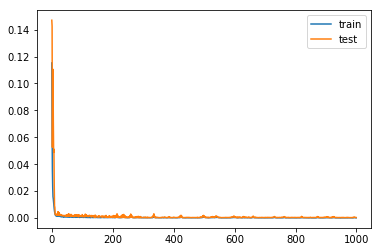

In [374]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

In [375]:
print(hist.history['val_loss'])


[0.1469857460435699, 0.14260473759735331, 0.052498884279938304, 0.08110772182836253, 0.11051994080052656, 0.0725513039266362, 0.0487737516489099, 0.05110337629037745, 0.02482143197866047, 0.009040681229260586, 0.008012851138654001, 0.002861816586707445, 0.0025621818974340227, 0.0030870147405520957, 0.0023145781323204145, 0.0021902660921435148, 0.002294490059070727, 0.0019712172215804458, 0.003107080796112046, 0.0021039339891799234, 0.004649452639141065, 0.00197930378935245, 0.004289196567911217, 0.002023809647653252, 0.00385429838549017, 0.0019593658054124236, 0.00268985066224345, 0.002568816623512676, 0.0022959620721795704, 0.0025746913347307675, 0.0017850689764600247, 0.002443478579259724, 0.0017275889609556865, 0.002051263632786097, 0.001901002528885489, 0.001975345807937522, 0.0019265355040261056, 0.0015497116461012732, 0.0016289214894213194, 0.0019156759483260376, 0.0016451027241761468, 0.0018566031559363611, 0.00181661632257815, 0.001746785625394242, 0.001517256796325776, 0.00191

In [376]:
reframed

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var11(t+2)
0,0.004108,0.812668,0.000000,0.000000,0.011813,0.005986,0.364549,0.012577,0.777328,0.287966,...,0.000000,0.000000,0.011135,0.000000,0.357859,0.000000,0.711032,0.191277,0.300492,0.315271
1,0.005649,0.784367,0.000000,0.000000,0.012940,0.007292,0.364549,0.022815,0.905870,0.213873,...,0.000000,0.000000,0.011540,0.002517,0.384615,0.003515,0.769737,0.254335,0.295566,0.300492
2,0.007190,0.762803,0.000000,0.009757,0.016043,0.015337,0.371238,0.035178,0.925607,0.197583,...,0.000000,0.000000,0.011813,0.005986,0.364549,0.012577,0.777328,0.287966,0.315271,0.275862
3,0.008730,0.765499,0.000000,0.009757,0.016473,0.025907,0.294314,0.043531,0.885121,0.230688,...,0.000000,0.000000,0.012940,0.007292,0.364549,0.022815,0.905870,0.213873,0.300492,0.266010
4,0.010785,0.783019,0.000000,0.009757,0.016369,0.030211,0.297659,0.051047,1.000000,0.252233,...,0.000000,0.009757,0.016043,0.015337,0.371238,0.035178,0.925607,0.197583,0.275862,0.246305
5,0.012839,0.791105,0.000000,0.009757,0.017281,0.038038,0.254181,0.055557,0.941802,0.276406,...,0.000000,0.009757,0.016473,0.025907,0.294314,0.043531,0.885121,0.230688,0.266010,0.216749
6,0.017461,0.842318,0.000000,0.019255,0.013679,0.049833,0.143813,0.063295,0.941296,0.368891,...,0.000000,0.009757,0.016369,0.030211,0.297659,0.051047,1.000000,0.252233,0.246305,0.152709
7,0.021569,0.870620,0.000000,0.019255,0.010031,0.055399,0.163880,0.076473,0.790486,0.442459,...,0.000000,0.009757,0.017281,0.038038,0.254181,0.055557,0.941802,0.276406,0.216749,0.152709
8,0.026705,0.939353,0.000000,0.019255,0.012293,0.052701,0.147157,0.082993,0.692814,0.562796,...,0.000000,0.019255,0.013679,0.049833,0.143813,0.063295,0.941296,0.368891,0.152709,0.133005
9,0.032354,0.959569,0.000000,0.019255,0.008085,0.057306,0.123746,0.095893,0.516700,0.519180,...,0.000000,0.019255,0.010031,0.055399,0.163880,0.076473,0.790486,0.442459,0.152709,0.128079


In [377]:
chat = model.predict(train_x)
yhat = model.predict(test_x)
chat
#test_x = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
#inv_yhat = np.concatenate((yhat, test_x[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = np.concatenate((test_y, test_x[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)

array([[0.30412912],
       [0.29612058],
       [0.28008616],
       [0.2583109 ],
       [0.2468001 ],
       [0.21324506],
       [0.15360302],
       [0.14723341],
       [0.12982875],
       [0.12839806],
       [0.17598239],
       [0.19291134],
       [0.25310653],
       [0.39594078],
       [0.6201349 ],
       [0.7069893 ],
       [0.6583565 ],
       [0.62378895],
       [0.56150025],
       [0.52838874],
       [0.54122263],
       [0.55173653],
       [0.52169   ],
       [0.4678266 ],
       [0.4313065 ],
       [0.39383823],
       [0.36199668],
       [0.30888423],
       [0.3099726 ],
       [0.289717  ],
       [0.28609362],
       [0.26570207],
       [0.28697467],
       [0.3002004 ],
       [0.34646797],
       [0.4915257 ],
       [0.54435   ],
       [0.50284135],
       [0.5084698 ],
       [0.49952146],
       [0.51313144],
       [0.62006116],
       [0.7040786 ],
       [0.78139323],
       [0.8667509 ],
       [0.9534318 ],
       [0.9261733 ],
       [0.879

In [378]:
#np.savetxt('data', reframed)
#np.savetxt('train', train)
#np.savetxt('test', test)

In [379]:
datadmin


3.9

In [380]:
datadmax

10.66667

In [381]:
corrected = test_y*(datadmax-datadmin)+datadmin

In [382]:
test_y

array([0.15763544, 0.15763544, 0.1231526 , 0.10837428, 0.10837428,
       0.07881765, 0.08866991, 0.08866991, 0.11330049, 0.13300486,
       0.1625615 , 0.21182251, 0.31034467, 0.43842348, 0.64531978,
       0.79802916, 0.84729017, 0.89162513, 0.87684681, 0.84729017,
       0.82265959, 0.8275858 , 0.75862041, 0.76354647, 0.75369421,
       0.699507  , 0.64531978, 0.63546767, 0.61083724, 0.5763544 ,
       0.56650213, 0.5369455 , 0.49753675, 0.44827559])

In [383]:
corrected

array([4.966667, 4.966667, 4.733333, 4.633333, 4.633333, 4.433333,
       4.5     , 4.5     , 4.666667, 4.8     , 5.      , 5.333333,
       6.      , 6.866667, 8.266666, 9.3     , 9.633333, 9.933333,
       9.833333, 9.633333, 9.466666, 9.5     , 9.033334, 9.066667,
       9.      , 8.633333, 8.266666, 8.2     , 8.033334, 7.8     ,
       7.733333, 7.533333, 7.266667, 6.933333])

In [384]:
correctedpred = yhat*(datadmax-datadmin)+datadmin
correctedpred = correctedpred.ravel()
correctedpred

array([4.9278975, 4.857247 , 4.6417766, 4.5473795, 4.57705  , 4.45942  ,
       4.4182954, 4.3875666, 4.438446 , 4.550346 , 4.924014 , 5.5047407,
       6.0156093, 6.7991643, 8.03442  , 9.116669 , 9.562033 , 9.947903 ,
       9.970335 , 9.806146 , 9.556428 , 9.539029 , 9.188082 , 8.963012 ,
       8.966921 , 8.693976 , 8.195898 , 8.029287 , 7.9225984, 7.7554884,
       7.711894 , 7.5440474, 7.1767955, 6.663141 ], dtype=float32)

In [385]:
#fixing for final results
#corrected = corrected[1:]
#correctedpred = correctedpred[1:]

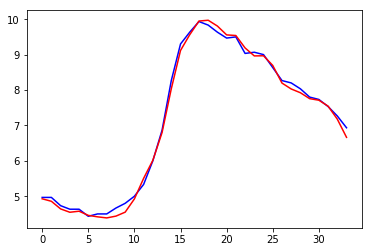

In [389]:
plt.plot(corrected, color = 'b')
plt.plot(correctedpred, color='R')
plt.savefig('bestLSTM.png')
plt.show()

In [390]:
mse = ((corrected[:-1]-correctedpred[:-1])**2).mean()
mse

0.013768066400127576

In [391]:
rmse = mse **(1/2)
rmse

0.11733740409659477

In [392]:
mse2 = ((test_y[-1]-yhat[-1].ravel()) **2).mean()
mse2

0.0015943967

In [31]:
rmse2 = mse2 **(1/2)
rmse2

0.06406915327739161

In [85]:
that = np.append(chat,yhat)
cthat = that*(datadmax-datadmin)+datadmin
ythat = np.append(train_y,test_y)
cythat = ythat*(datadmax-datadmin)+datadmin

print(len(correctedpred))

34


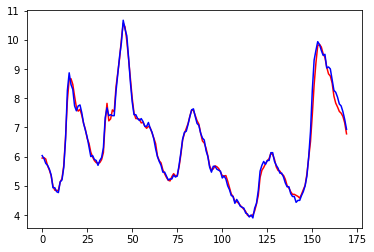

In [86]:
plt.plot(cthat, color = 'red')
plt.plot(cythat, color = 'b')
plt.show()



In [87]:
#lstmpred = pd.DataFrame(correctedpred)
#lstmpred.to_csv('lstmpred.csv')

In [88]:
corrected

array([4.966667, 4.966667, 4.733333, 4.633333, 4.633333, 4.433333,
       4.5     , 4.5     , 4.666667, 4.8     , 5.      , 5.333333,
       6.      , 6.866667, 8.266666, 9.3     , 9.633333, 9.933333,
       9.833333, 9.633333, 9.466666, 9.5     , 9.033334, 9.066667,
       9.      , 8.633333, 8.266666, 8.2     , 8.033334, 7.8     ,
       7.733333, 7.533333, 7.266667, 6.933333])

In [89]:
cccc= model.evaluate(test_x, test_y)
print(cccc)

34/34 [==============================] - 0s 147us/step
0.0015967841746340342


Convert RMSE from Rohit's fnn

In [90]:
rmselgfnnminimized = 0.04766
rmselgfnn = rmselgfnnminimized*(datadmax-datadmin)
print(rmselgfnn)

0.32249949219999996


In [91]:
rmsefnnmin = 0.05128 
rmsefnn = rmsefnnmin* (datadmax-datadmin)
print(rmsefnn)

0.3469948376


In [150]:

dates.index=range(34)
correctedpreddf = pd.DataFrame(correctedpred)
correcteddf = pd.DataFrame(corrected)
lstmgraph = pd.concat([correctedpreddf, correcteddf], ignore_index=True, join='outer', axis=1)
lstmgraphs = lstmgraph.join(dates)

print(lstmgraphs)

           0         1     DATE
0   5.007432  4.966667  2005-Q3
1   4.923615  4.966667  2005-Q4
2   4.797026  4.733333  2006-Q1
3   4.707138  4.633333  2006-Q2
4   4.707228  4.633333  2006-Q3
5   4.673553  4.433333  2006-Q4
6   4.637179  4.500000  2007-Q1
7   4.579552  4.500000  2007-Q2
8   4.708280  4.666667  2007-Q3
9   4.867116  4.800000  2007-Q4
10  5.012656  5.000000  2008-Q1
11  5.405794  5.333333  2008-Q2
12  5.966443  6.000000  2008-Q3
13  6.516630  6.866667  2008-Q4
14  7.435602  8.266666  2009-Q1
15  8.452121  9.300000  2009-Q2
16  9.203259  9.633333  2009-Q3
17  9.792269  9.933333  2009-Q4
18  9.839908  9.833333  2010-Q1
19  9.750477  9.633333  2010-Q2
20  9.522014  9.466666  2010-Q3
21  9.395329  9.500000  2010-Q4
22  9.062531  9.033334  2011-Q1
23  8.830804  9.066667  2011-Q2
24  8.756750  9.000000  2011-Q3
25  8.520042  8.633333  2011-Q4
26  8.067394  8.266666  2012-Q1
27  7.829520  8.200000  2012-Q2
28  7.698093  8.033334  2012-Q3
29  7.545633  7.800000  2012-Q4
30  7.48

In [151]:
lstmgraphs.index = pd.to_datetime(lstmgraphs['DATE'])

lstmgraphs2 = lstmgraphs.iloc[:,0:2]
lstmgraphs2.columns = ['Prediction', 'Actual']
lstmgraphs.columns = ['Prediction', 'Actual', 'Date']
lstmgraphs2

,Prediction,Actual
DATE,,
2005-07-01,5.007432,4.966667
2005-10-01,4.923615,4.966667
2006-01-01,4.797026,4.733333
2006-04-01,4.707138,4.633333
2006-07-01,4.707228,4.633333
2006-10-01,4.673553,4.433333
2007-01-01,4.637179,4.500000
2007-04-01,4.579552,4.500000
2007-07-01,4.708280,4.666667


In [152]:
sns.tsplot(data = lstmgraphs2)

C:\Users\Wil Grebner\Documents\python\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


ValueError: cannot label index with a null key